<a href="https://colab.research.google.com/github/sasergeevna/python_projects.github.io/blob/main/Telecom_Customer_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ оттока клиентов телеком-компании и поиск факторов удержания
## Цель:
- Определить ключевые факторы, влияющие на отток клиентов;
- Провести продуктовую сегментацию и выявить группы с наибольшим риском;
- Построить воронку удержания и выявить критические периоды ухода;
- Оценить экономические потери от оттока (ARPU, LTV);
- Сформулировать бизнес-рекомендации для снижения оттока и увеличения выручки;

## Бизнес-задачи и значимость:
- Рост удержания клиентов: сокращение оттока на 5–10% может дать миллионы долларов дополнительной выручки в год;
- Оптимизация продуктовых предложений: выявить, какие доп. сервисы уменьшаю отток;
- Улучшение customer journey: первый месяц критически важен (отток ~60%), нужны welcome-акции и обучение клиента;
- Оплата электронным чеком приводит к высокому оттоку, стоит стимулировать переход на автоплатеж/карту.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

In [2]:
data = pd.read_csv('/content/customer_churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Описание переменных:
- customerlD - идентификатор клиента;
- gender - пол;
- SeniorCitizen - флаг пенсионера;
- Partner - флаг наличия семейных отношений;
- Dependents - флаг наличия иждивенцев в семье;
- tenure -количество месяцев, которое клиент остается с кампанией;
- PhoneService - флаг подключения телефонных сервисов;
-  MultipleLines - флаг подключения нескольких телефонных линий;
- InternetService - тип интернета, предоставляемого провайдером;
-  OnlineSecurity - флаг подключения онлайн защиты;
- OnlineBackup - флаг наличия онлайнового резервного копировани;
-  DeviceProtection - флаг подключения защиты устройства;
-  TechSupport - флаг наличия технической поддержки;
-  StreamingTV - флаг наличия ТВ;
-  StreamingMovies - флаг наличия доступа к фильмам;
- Contract- тип контракта;
- PaperlessBilling - флаг выставления электронного счета;
- PaymentMethod - способ оплаты;
- MonthlyCharges - размер месячной платы за услуги;
- TotalCharges - выплачено клиентом за все время жизни в компании;
- Churn - флаг оттока;

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
data.SeniorCitizen = data.SeniorCitizen.astype('object')

In [5]:
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])
print(data['TotalCharges'].dtype)
data[['MonthlyCharges', 'TotalCharges']].describe()

float64


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


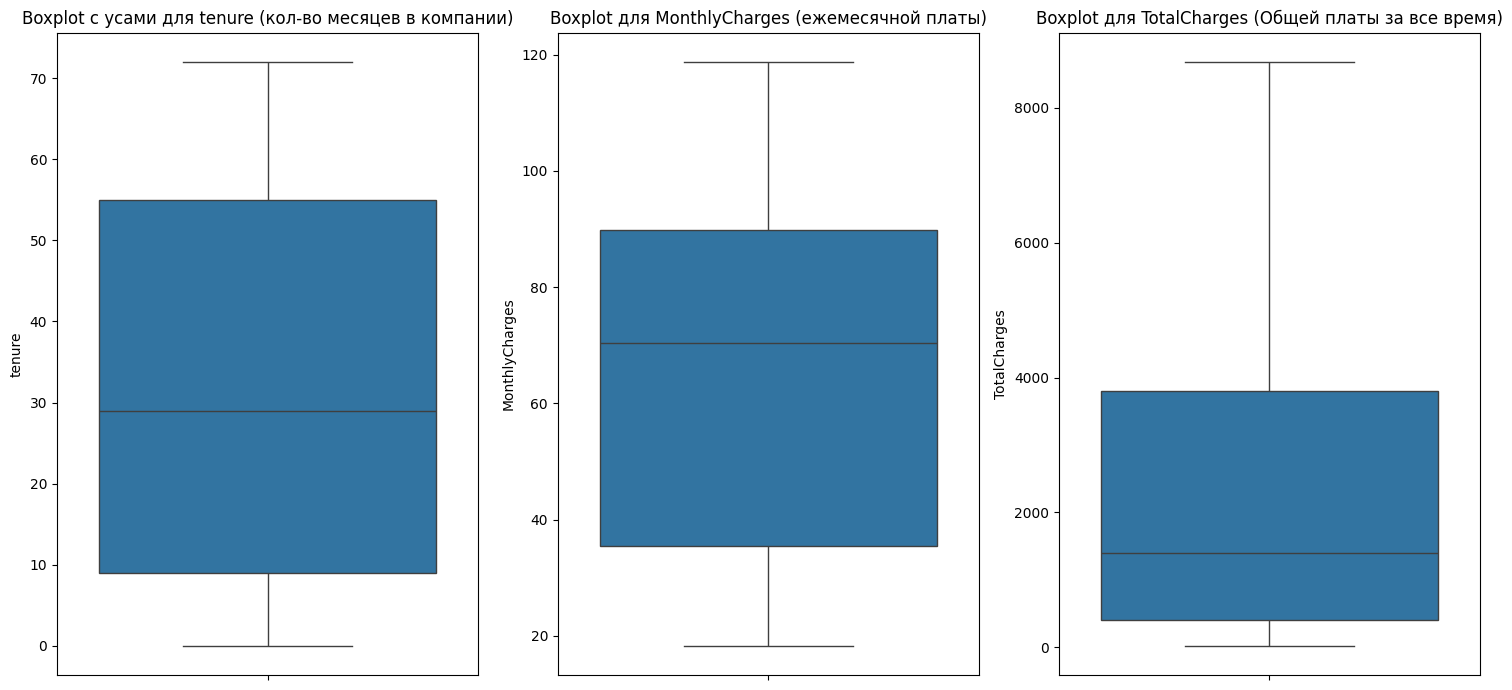

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15,7))

sns.boxplot(y=data['tenure'], ax=axes[0])
axes[0].set_title('Boxplot с усами для tenure (кол-во месяцев в компании)')

sns.boxplot(y=data['MonthlyCharges'], ax=axes[1])
axes[1].set_title('Boxplot для MonthlyCharges (ежемесячной платы)')

sns.boxplot(y=data['TotalCharges'], ax=axes[2])
axes[2].set_title('Boxplot для TotalCharges (Общей платы за все время)')

plt.tight_layout()
plt.show()

In [7]:
numeric_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

Q1 = data[numeric_vars].quantile(0.25)
Q3 = data[numeric_vars].quantile(0.75)
IQR = Q3 - Q1

print("Межквартильный размах для каждого признака:")
print(IQR)

Межквартильный размах для каждого признака:
tenure              46.0000
MonthlyCharges      54.3500
TotalCharges      3393.2875
dtype: float64


In [8]:
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print("Нижние границы для выбросов:")
print(lower)
print("\nВерхние границы для выбросов:")
print(upper)

Нижние границы для выбросов:
tenure             -60.00000
MonthlyCharges     -46.02500
TotalCharges     -4688.48125
dtype: float64

Верхние границы для выбросов:
tenure             124.00000
MonthlyCharges     171.37500
TotalCharges      8884.66875
dtype: float64


В данном случае нет смысла очищать данные от выбросов, так как в этих переменных выбросы являются нашими наиболее лояльными клинтами.

In [9]:
median_total_charges = data['TotalCharges'].median()
data['TotalCharges'] = data['TotalCharges'].fillna(median_total_charges)

In [10]:
binary_map = {'Yes': 1, 'No': 0}

data['Partner'] = data['Partner'].map(binary_map)
data['Dependents'] = data['Dependents'].map(binary_map)
data['PhoneService'] = data['PhoneService'].map(binary_map)
data['PaperlessBilling'] = data['PaperlessBilling'].map(binary_map)
data['Churn'] = data['Churn'].map(binary_map)

data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})

binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService',
                  'PaperlessBilling', 'Churn', 'PhoneService']
for col in binary_columns:
    print(f"{col}: {data[col].unique()}")

gender: [0 1]
Partner: [1 0]
Dependents: [0 1]
PhoneService: [0 1]
PaperlessBilling: [1 0]
Churn: [0 1]
PhoneService: [0 1]


## Разведочный анализ данных

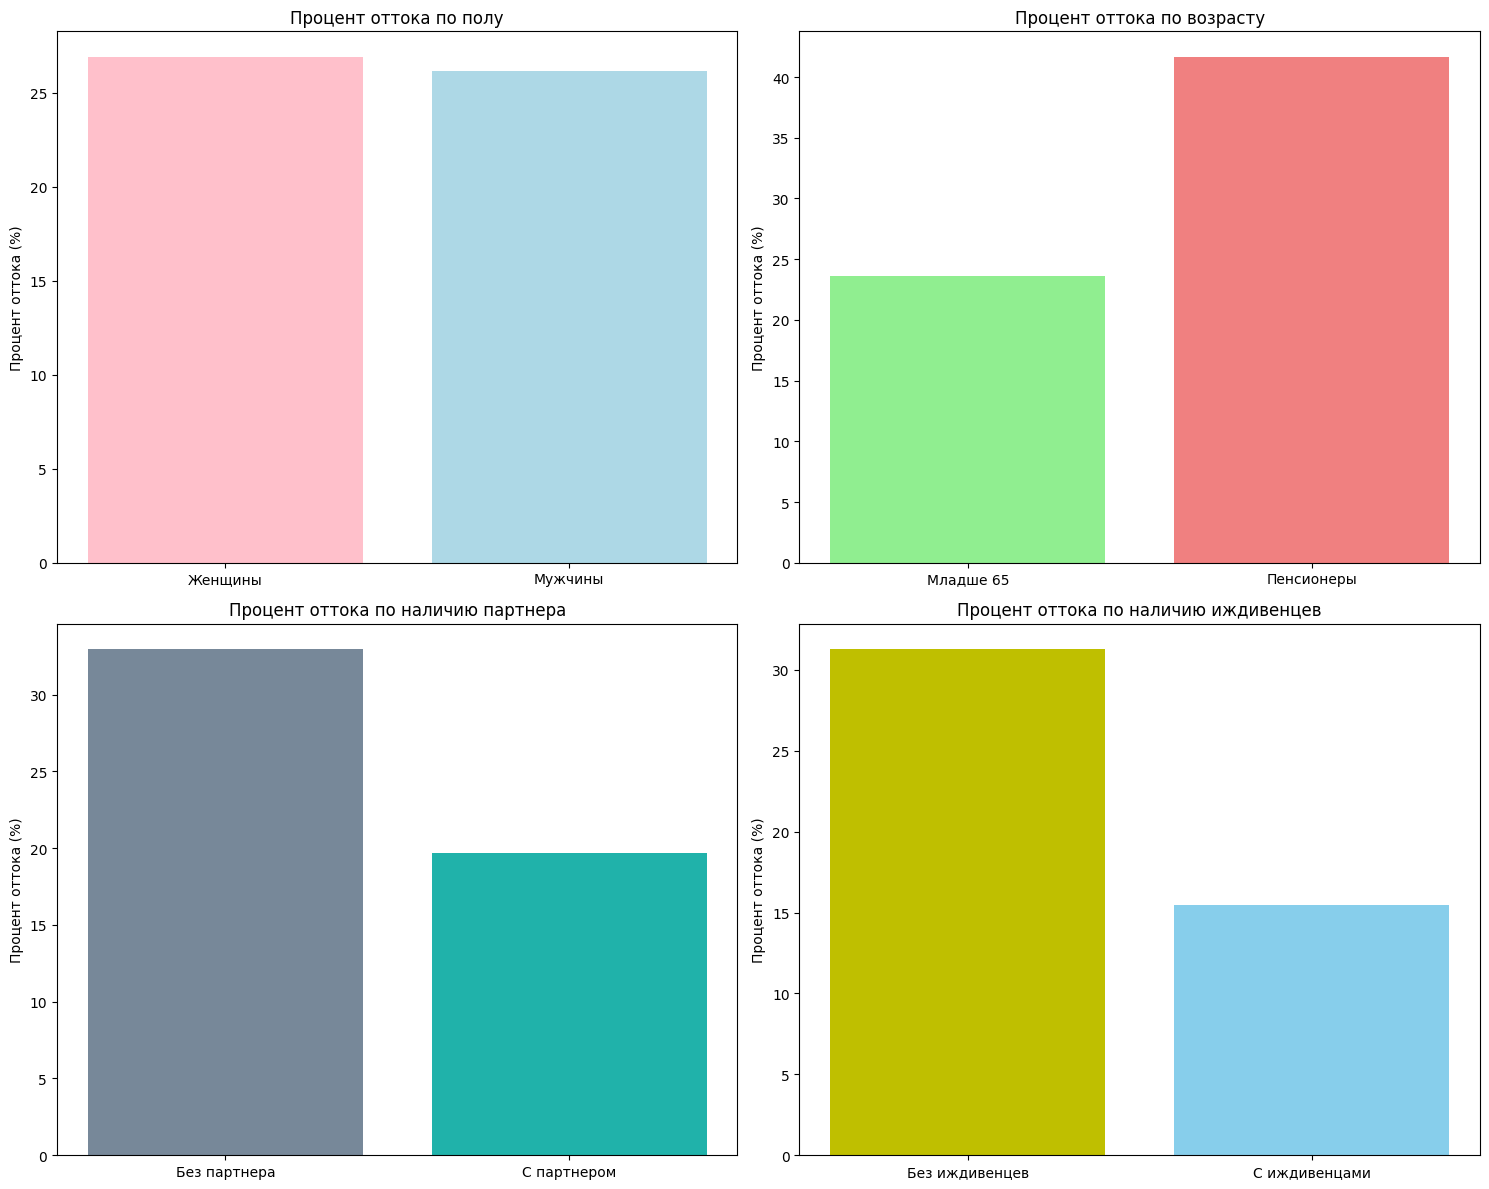

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

churn_gender = data.groupby('gender')['Churn'].mean() * 100
axes[0,0].bar(churn_gender.index, churn_gender.values, color=['pink', 'lightblue'])
axes[0,0].set_title('Процент оттока по полу')
axes[0,0].set_ylabel('Процент оттока (%)')
axes[0,0].set_xticks([0, 1])
axes[0,0].set_xticklabels(['Женщины', 'Мужчины'])

churn_senior = data.groupby('SeniorCitizen')['Churn'].mean() * 100
axes[0,1].bar(churn_senior.index, churn_senior.values, color=['lightgreen', 'lightcoral'])
axes[0,1].set_title('Процент оттока по возрасту')
axes[0,1].set_ylabel('Процент оттока (%)')
axes[0,1].set_xticks([0, 1])
axes[0,1].set_xticklabels(['Младше 65', 'Пенсионеры'])


churn_partner = data.groupby('Partner')['Churn'].mean() * 100
axes[1,0].bar(churn_partner.index, churn_partner.values, color=['lightslategrey', 'lightseagreen'])
axes[1,0].set_title('Процент оттока по наличию партнера')
axes[1,0].set_ylabel('Процент оттока (%)')
axes[1,0].set_xticks([0, 1])
axes[1,0].set_xticklabels(['Без партнера', 'С партнером'])


churn_dep = data.groupby('Dependents')['Churn'].mean() * 100
axes[1,1].bar(churn_dep.index, churn_dep.values, color=['y', 'skyblue'])
axes[1,1].set_title('Процент оттока по наличию иждивенцев')
axes[1,1].set_ylabel('Процент оттока (%)')
axes[1,1].set_xticks([0, 1])
axes[1,1].set_xticklabels(['Без иждивенцев', 'С иждивенцами'])

plt.tight_layout()
plt.show()

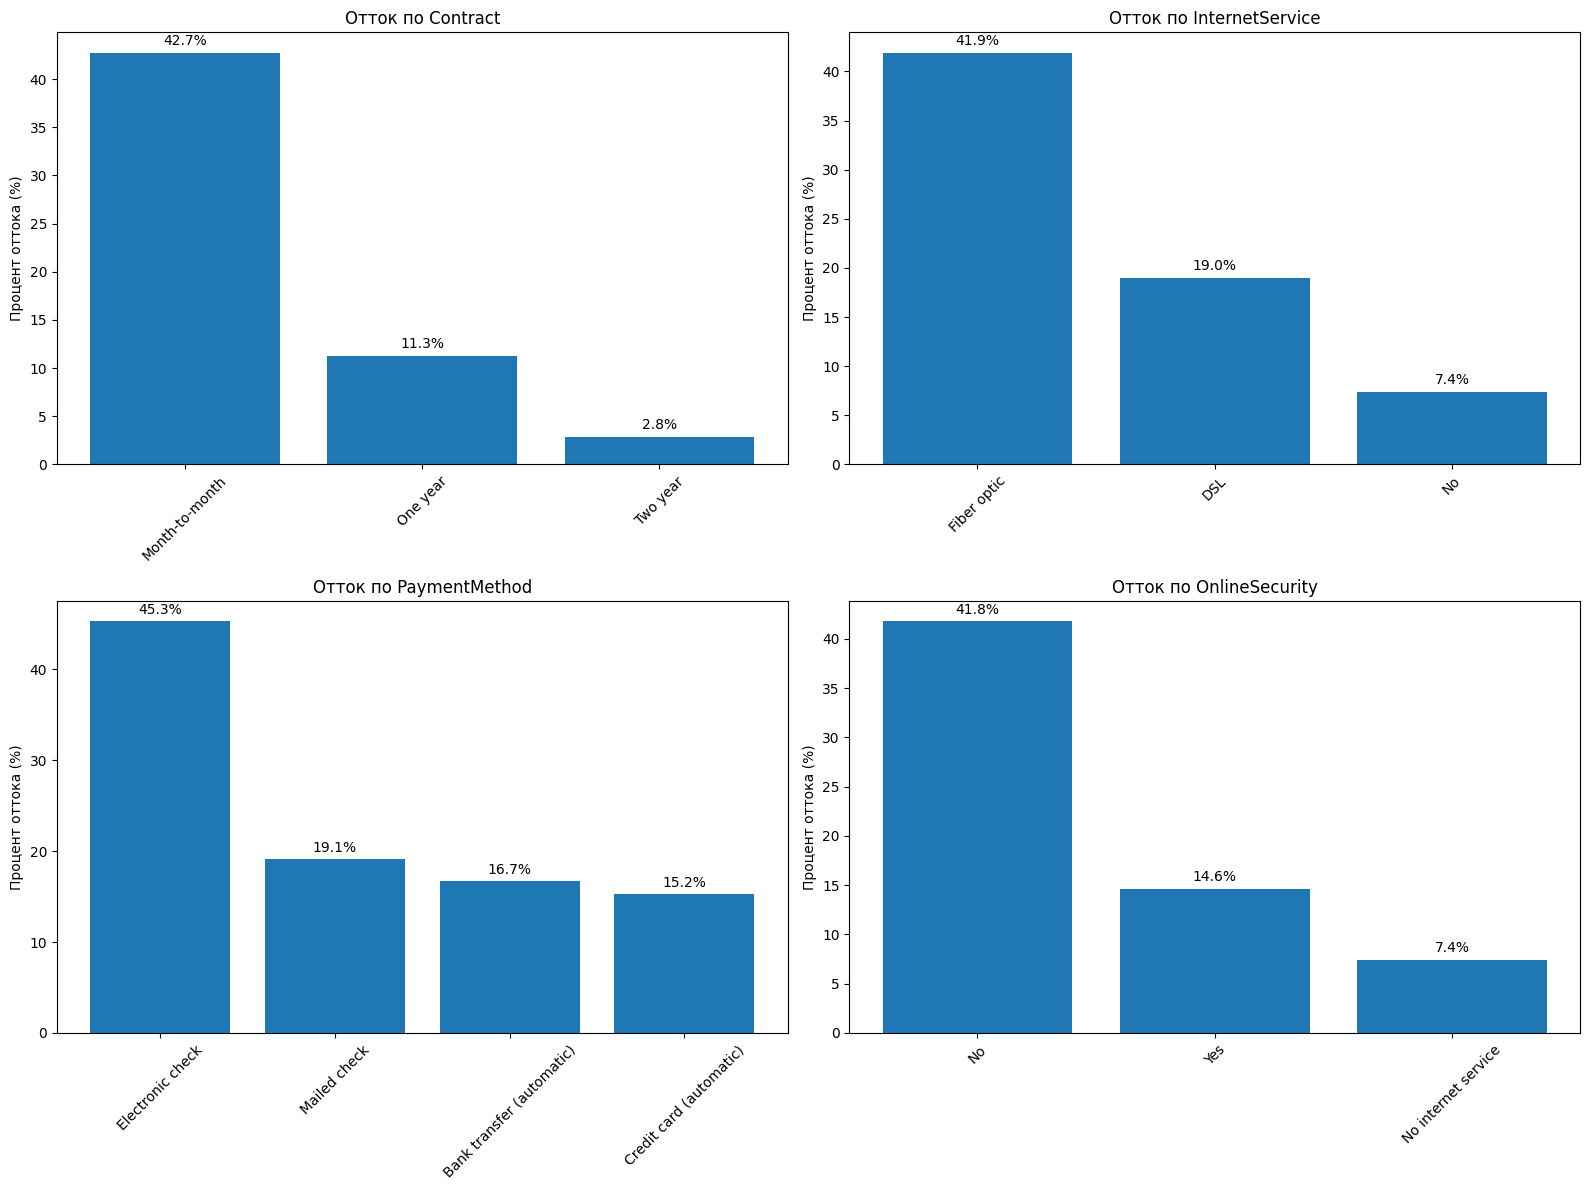

In [12]:
main_factors = ['Contract', 'InternetService', 'PaymentMethod', 'OnlineSecurity']

plt.figure(figsize=(16, 12))
for i, factor in enumerate(main_factors, 1):
    plt.subplot(2, 2, i)
    churn_by_factor = data.groupby(factor)['Churn'].mean().sort_values(ascending=False) * 100
    bars = plt.bar(range(len(churn_by_factor)), churn_by_factor.values)
    plt.title(f'Отток по {factor}')
    plt.ylabel('Процент оттока (%)')
    plt.xticks(range(len(churn_by_factor)), churn_by_factor.index, rotation=45)

    for bar, value in zip(bars, churn_by_factor.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [13]:
print("Анализ причин оттока:")
print("=" * 50)

print("\n1. Факторы с наибольшим оттоком:")
high_churn_factors = {}
for column in data.select_dtypes(include=['object']).columns:
    if column != 'customerID':
        churn_rate = data.groupby(column)['Churn'].mean().max() * 100
        high_churn_factors[column] = churn_rate

for factor, rate in sorted(high_churn_factors.items(), key=lambda x: x[1], reverse=True)[:5]:
    value = data.groupby(factor)['Churn'].mean().idxmax()
    print(f"{factor} = {value}: {rate:.1f}% оттока")

print("\n2. Срок обслуживания:")
tenure_churn = data.groupby(pd.cut(data['tenure'], bins=[0, 12, 24, 36, 48, 100]))['Churn'].mean() * 100
print("Отток по сроку обслуживания:")
for interval, rate in tenure_churn.items():
    print(f"{interval}: {rate:.1f}%")

print("\n3. Ежемесячные платежи:")
print(f"Средний месячный платеж ушедших: ${data[data['Churn']==1]['MonthlyCharges'].mean():.2f}")
print(f"Средний месячный платеж лояльных: ${data[data['Churn']==0]['MonthlyCharges'].mean():.2f}")


Анализ причин оттока:

1. Факторы с наибольшим оттоком:
PaymentMethod = Electronic check: 45.3% оттока
Contract = Month-to-month: 42.7% оттока
InternetService = Fiber optic: 41.9% оттока
OnlineSecurity = No: 41.8% оттока
SeniorCitizen = 1: 41.7% оттока

2. Срок обслуживания:
Отток по сроку обслуживания:
(0, 12]: 47.7%
(12, 24]: 28.7%
(24, 36]: 21.6%
(36, 48]: 19.0%
(48, 100]: 9.5%

3. Ежемесячные платежи:
Средний месячный платеж ушедших: $74.44
Средний месячный платеж лояльных: $61.27


/tmp/ipython-input-4128511818.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = data.groupby(pd.cut(data['tenure'], bins=[0, 12, 24, 36, 48, 100]))['Churn'].mean() * 100


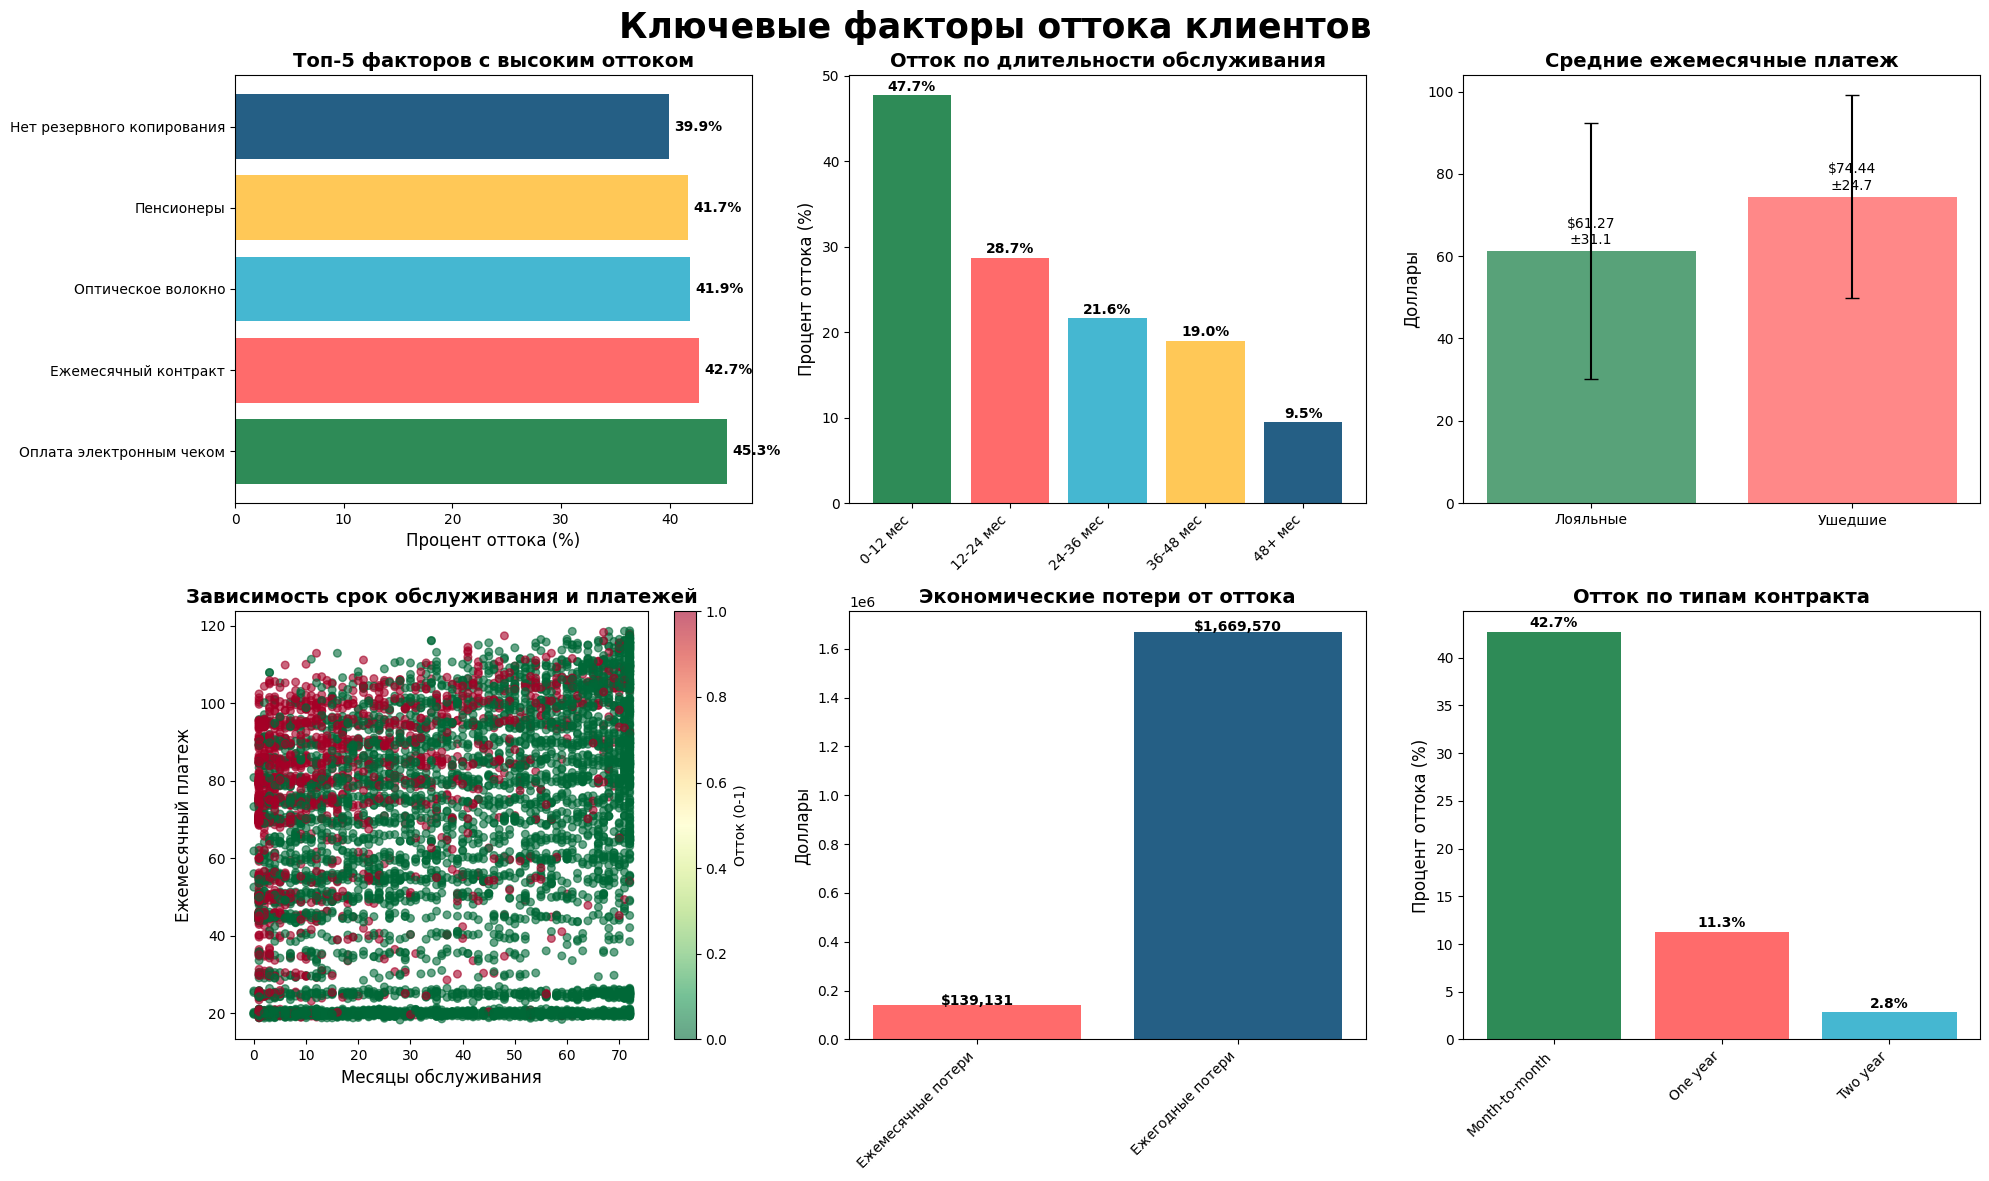

In [14]:
main_colors = ['#2E8B57', '#FF6B6B', '#45B7D1', '#FFC857', '#255F85']

fig = plt.figure(figsize=(20, 12))
plt.suptitle('Ключевые факторы оттока клиентов', fontsize=25, fontweight='bold')

plt.subplot(2, 3, 1)
top_factors = {
    'Оплата электронным чеком': 45.3,
    'Ежемесячный контракт': 42.7,
    'Оптическое волокно': 41.9,
    'Пенсионеры': 41.7,
    'Нет резервного копирования': 39.9
}
bars = plt.barh(list(top_factors.keys()), list(top_factors.values()), color=main_colors)
plt.xlabel('Процент оттока (%)', fontsize=12)
plt.title('Топ-5 факторов с высоким оттоком', fontsize=14, fontweight='bold')
for bar, value in zip(bars, top_factors.values()):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{value}%',
             va='center', fontweight='bold', fontsize=10)

plt.subplot(2, 3, 2)
tenure_bins = ['0-12 мес', '12-24 мес', '24-36 мес', '36-48 мес', '48+ мес']
tenure_rates = [47.7, 28.7, 21.6, 19.0, 9.5]
bars = plt.bar(tenure_bins, tenure_rates, color=main_colors)
plt.title('Отток по длительности обслуживания', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Процент оттока (%)', fontsize=12)
for bar, value in zip(bars, tenure_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{value}%',
             ha='center', fontweight='bold', fontsize=10)


plt.subplot(2, 3, 3)
charges_data = {
    'Лояльные': [61.27, data[data['Churn'] == 0]['MonthlyCharges'].std()],
    'Ушедшие': [74.44, data[data['Churn'] == 1]['MonthlyCharges'].std()]
}

x_pos = np.arange(len(charges_data))
means = [charges_data[key][0] for key in charges_data.keys()]
stds = [charges_data[key][1] for key in charges_data.keys()]

bars = plt.bar(charges_data.keys(), means, yerr=stds,
               capsize=5, color=[main_colors[0], main_colors[1]], alpha=0.8)
plt.title('Средние ежемесячные платеж', fontsize=14, fontweight='bold')
plt.ylabel('Доллары', fontsize=12)

for bar, mean, std in zip(bars, means, stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'${mean:.2f}\n±{std:.1f}', ha='center', va='bottom', fontsize=10)

plt.subplot(2, 3, 4)
scatter = plt.scatter(data['tenure'], data['MonthlyCharges'],
                     c=data['Churn'], cmap='RdYlGn_r', alpha=0.6, s=30)
plt.colorbar(scatter, label='Отток (0-1)')
plt.title('Зависимость срок обслуживания и платежей', fontsize=14, fontweight='bold')
plt.xlabel('Месяцы обслуживания', fontsize=12)
plt.ylabel('Ежемесячный платеж', fontsize=12)

plt.subplot(2, 3, 5)
monthly_loss = data[data['Churn'] == 1]['MonthlyCharges'].sum()
annual_loss = monthly_loss * 12

loss_data = [monthly_loss, annual_loss]
labels = ['Ежемесячные потери', 'Ежегодные потери']

bars = plt.bar(labels, loss_data, color=[main_colors[1], main_colors[4]])
plt.title('Экономические потери от оттока', fontsize=14, fontweight='bold')
plt.ylabel('Доллары', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar, value in zip(bars, loss_data):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'${value:,.0f}', ha='center', fontweight='bold', fontsize=10)

plt.subplot(2, 3, 6)
contract_churn = data.groupby('Contract')['Churn'].mean() * 100
contract_churn = contract_churn.sort_values(ascending=False)

bars = plt.bar(contract_churn.index, contract_churn.values, color=main_colors)
plt.title('Отток по типам контракта', fontsize=14, fontweight='bold')
plt.ylabel('Процент оттока (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar, value in zip(bars, contract_churn.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}%', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

##Создадим более детальные продуктовые сегменты

In [15]:
def create_customer_segments(row):
    if row['InternetService'] == 'Fiber optic':
        internet_type = 'Fiber'
    elif row['InternetService'] == 'DSL':
        internet_type = 'DSL'
    else:
        internet_type = 'No_Internet'


    services_count = sum([
        row['OnlineSecurity'] == 1,
        row['OnlineBackup'] == 1,
        row['DeviceProtection'] == 1,
        row['TechSupport'] == 1,
        row['StreamingTV'] == 1,
        row['StreamingMovies'] == 1
    ])

    if services_count >= 4:
        service_level = 'Power_User'
    elif services_count >= 2:
        service_level = 'Medium_User'
    else:
        service_level = 'Basic_User'

    contract_type = row['Contract'].replace('-', '_').replace(' ', '_')

    return f"{internet_type}_{service_level}_{contract_type}"

data['customer_segment'] = data.apply(create_customer_segments, axis=1)

segment_analysis = data.groupby('customer_segment').agg({
    'Churn': ['count', 'mean'],
    'MonthlyCharges': 'mean',
    'tenure': 'mean',
    'TotalCharges': 'mean'
}).round(2)

segment_analysis.columns = ['Количество_клиентов', 'Процент_оттока', 'Средний_месячный_платеж',
                           'Средний_срок_обслуживания', 'Средняя_общая_выручка']
segment_analysis['Процент_оттока'] = segment_analysis['Процент_оттока'] * 100

print("Анализ продуктовых сегментов:")
print("=" * 60)
print(segment_analysis.sort_values('Процент_оттока', ascending=False))

Анализ продуктовых сегментов:
                                       Количество_клиентов  Процент_оттока  \
customer_segment                                                             
Fiber_Basic_User_Month_to_month                       2128            55.0   
DSL_Basic_User_Month_to_month                         1223            32.0   
Fiber_Basic_User_One_year                              539            19.0   
No_Internet_Basic_User_Month_to_month                  524            19.0   
DSL_Basic_User_One_year                                570             9.0   
Fiber_Basic_User_Two_year                              429             7.0   
DSL_Basic_User_Two_year                                628             2.0   
No_Internet_Basic_User_One_year                        364             2.0   
No_Internet_Basic_User_Two_year                        638             1.0   

                                       Средний_месячный_платеж  \
customer_segment                             

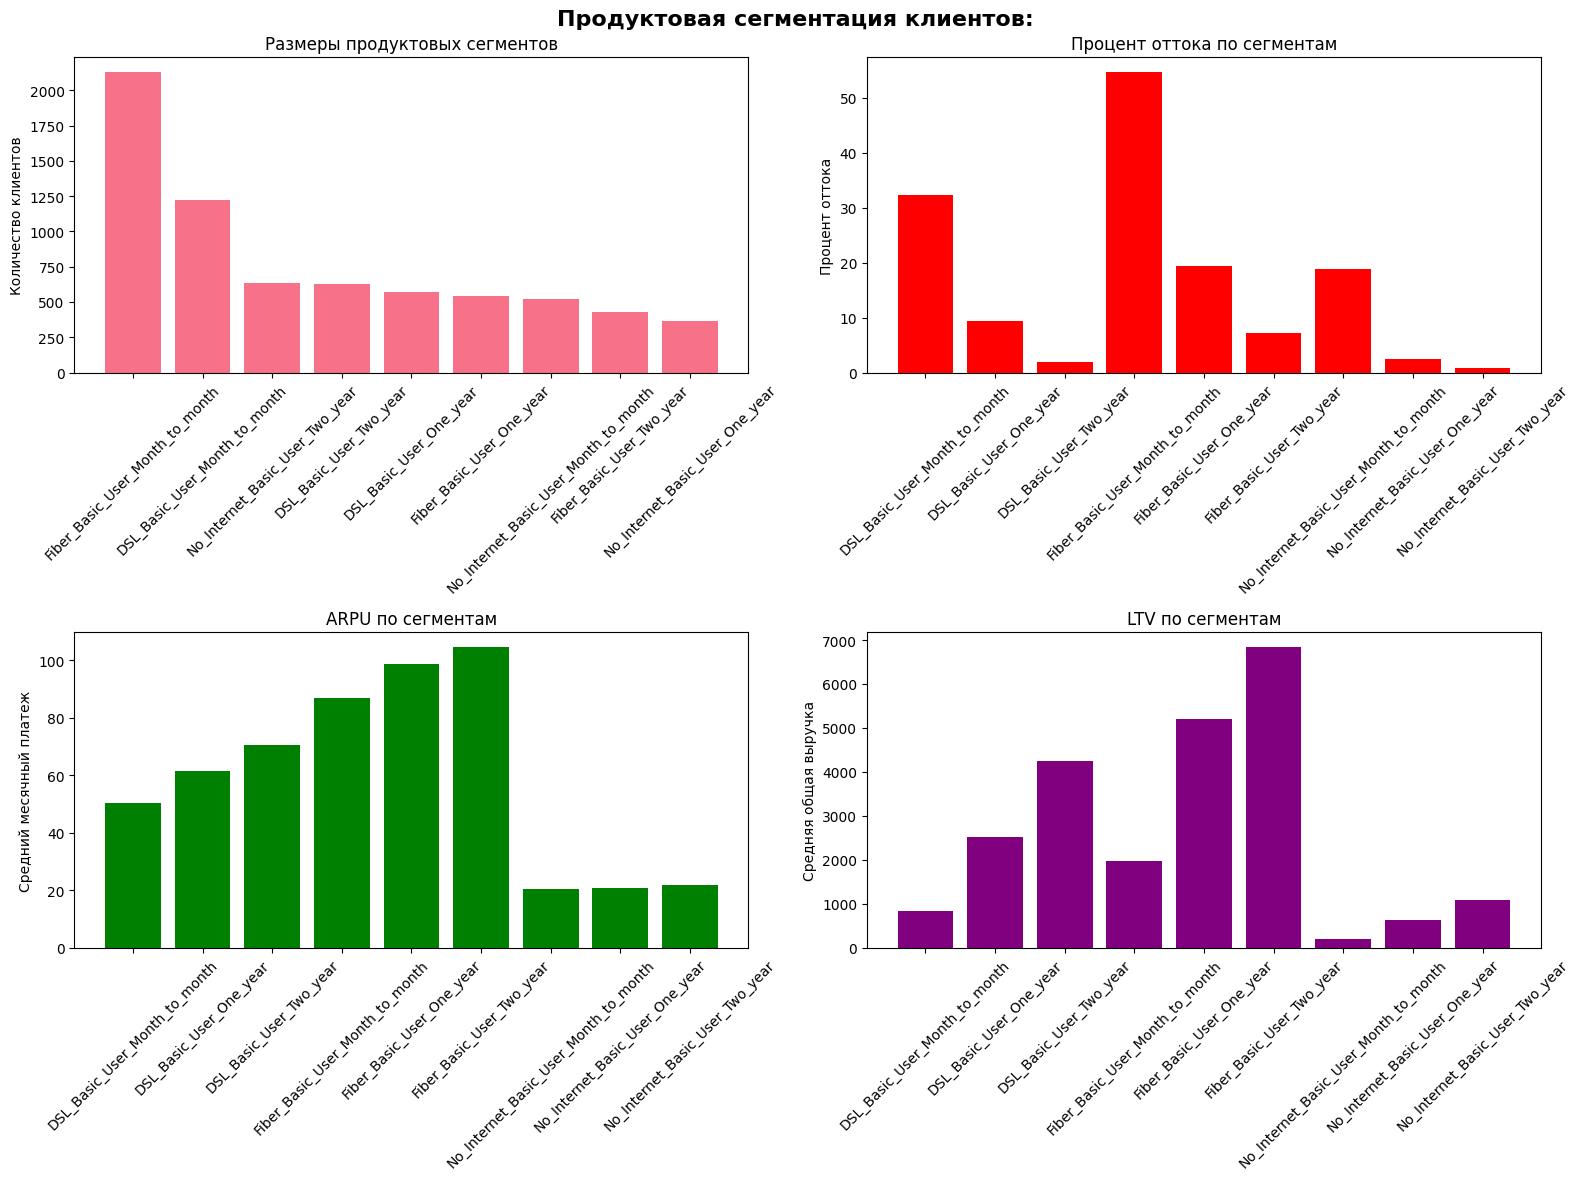

In [16]:
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Продуктовая сегментация клиентов:', fontsize=16, fontweight='bold')

segment_sizes = data['customer_segment'].value_counts()
axes[0,0].bar(segment_sizes.index, segment_sizes.values)
axes[0,0].set_title('Размеры продуктовых сегментов')
axes[0,0].set_ylabel('Количество клиентов')
axes[0,0].tick_params(axis='x', rotation=45)

segment_churn = data.groupby('customer_segment')['Churn'].mean() * 100 #Отток по сегментам
axes[0,1].bar(segment_churn.index, segment_churn.values, color='red')
axes[0,1].set_title('Процент оттока по сегментам')
axes[0,1].set_ylabel('Процент оттока')
axes[0,1].tick_params(axis='x', rotation=45)

segment_arpu = data.groupby('customer_segment')['MonthlyCharges'].mean()#ARPU (Average Revenue Per User) по сегментам
axes[1,0].bar(segment_arpu.index, segment_arpu.values, color='green')
axes[1,0].set_title('ARPU по сегментам')
axes[1,0].set_ylabel('Средний месячный платеж')
axes[1,0].tick_params(axis='x', rotation=45)


segment_ltv = data.groupby('customer_segment')['TotalCharges'].mean() #LTV (Lifetime Value) по сегментам
axes[1,1].bar(segment_ltv.index, segment_ltv.values, color='purple')
axes[1,1].set_title('LTV по сегментам')
axes[1,1].set_ylabel('Средняя общая выручка')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [17]:
high_churn_segments = segment_analysis[segment_analysis['Процент_оттока'] > 30]
print("Сегменты с высоким оттоком (>30%):")
print("=" * 40)
print(high_churn_segments)

for segment in high_churn_segments.index:
    segment_data = data[data['customer_segment'] == segment]
    print(f"\n Сегмент: {segment}")
    print(f"   • Размер: {len(segment_data)} клиентов")
    print(f"   • Отток: {segment_data['Churn'].mean()*100:.1f}%")
    print(f"   • ARPU: ${segment_data['MonthlyCharges'].mean():.2f}")
    print(f"   • Средний срок: {segment_data['tenure'].mean():.1f} месяцев")
    print(f"   • Популярные платежные методы: {segment_data['PaymentMethod'].value_counts().index[0]}")

Сегменты с высоким оттоком (>30%):
                                 Количество_клиентов  Процент_оттока  \
customer_segment                                                       
DSL_Basic_User_Month_to_month                   1223            32.0   
Fiber_Basic_User_Month_to_month                 2128            55.0   

                                 Средний_месячный_платеж  \
customer_segment                                           
DSL_Basic_User_Month_to_month                      50.22   
Fiber_Basic_User_Month_to_month                    87.02   

                                 Средний_срок_обслуживания  \
customer_segment                                             
DSL_Basic_User_Month_to_month                        15.73   
Fiber_Basic_User_Month_to_month                      21.55   

                                 Средняя_общая_выручка  
customer_segment                                        
DSL_Basic_User_Month_to_month                   830.04  
Fiber_Basic_Use

## Проведем анализ воронки удержания по сроку обслужиния

In [18]:
retention_bins = [0, 1, 3, 6, 12, 24, 36, 48, 60, 72]
retention_labels = ['1 месяц', '3 месяца', '6 месяцев', '1 год', '2 года', '3 года', '4 года', '5 лет', '6+ лет']

data['retention_group'] = pd.cut(data['tenure'], bins=retention_bins, labels=retention_labels, right=False)

retention_analysis = data.groupby('retention_group').agg({
    'customerID': 'count',
    'Churn': 'mean'
}).round(3)

retention_analysis.columns = ['Количество_клиентов', 'Процент_оттока']
retention_analysis['Процент_удержания'] = (1 - retention_analysis['Процент_оттока']) * 100
retention_analysis['Процент_оттока'] = retention_analysis['Процент_оттока'] * 100

retention_analysis['Накопленный_отток'] = retention_analysis['Процент_оттока'].cumsum()
retention_analysis['Доля_от_общего'] = (retention_analysis['Количество_клиентов'] / len(data)) * 100

print("Воронка удержания по сроку обслуживания:")
print("=" * 60)
print(retention_analysis)

Воронка удержания по сроку обслуживания:
                 Количество_клиентов  Процент_оттока  Процент_удержания  \
retention_group                                                           
1 месяц                           11             0.0              100.0   
3 месяца                         851            59.1               40.9   
6 месяцев                        509            47.3               52.7   
1 год                            698            36.5               63.5   
2 года                          1047            29.5               70.5   
3 года                           876            22.0               78.0   
4 года                           748            19.5               80.5   
5 лет                            820            15.0               85.0   
6+ лет                          1121             8.3               91.7   

                 Накопленный_отток  Доля_от_общего  
retention_group                                     
1 месяц                    

/tmp/ipython-input-410120616.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_analysis = data.groupby('retention_group').agg({


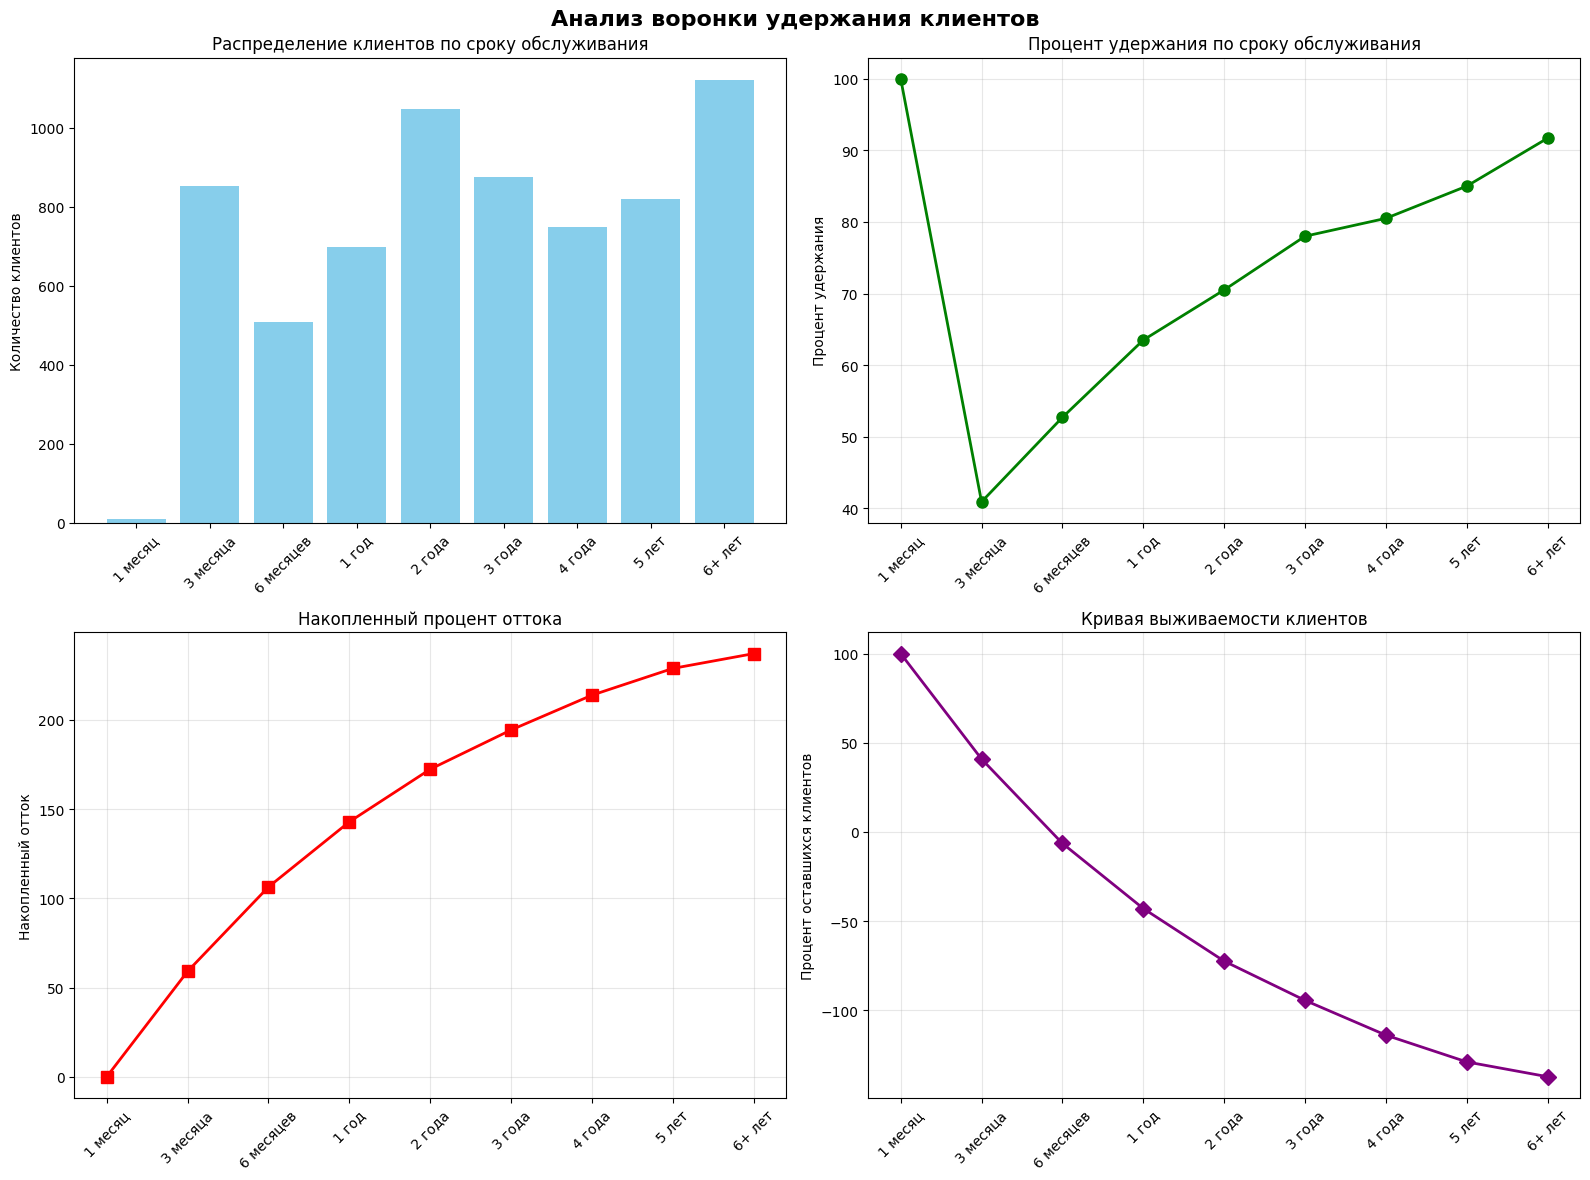

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Анализ воронки удержания клиентов', fontsize=16, fontweight='bold')

axes[0,0].bar(retention_analysis.index, retention_analysis['Количество_клиентов'], color='skyblue')
axes[0,0].set_title('Распределение клиентов по сроку обслуживания')
axes[0,0].set_ylabel('Количество клиентов')
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].plot(retention_analysis.index, retention_analysis['Процент_удержания'],
               marker='o', linewidth=2, markersize=8, color='green')
axes[0,1].set_title('Процент удержания по сроку обслуживания')
axes[0,1].set_ylabel('Процент удержания')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(retention_analysis.index, retention_analysis['Накопленный_отток'],
               marker='s', linewidth=2, markersize=8, color='red')
axes[1,0].set_title('Накопленный процент оттока')
axes[1,0].set_ylabel('Накопленный отток')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

survival_rate = 100 - retention_analysis['Накопленный_отток']
axes[1,1].plot(retention_analysis.index, survival_rate,
               marker='D', linewidth=2, markersize=8, color='purple')
axes[1,1].set_title('Кривая выживаемости клиентов')
axes[1,1].set_ylabel('Процент оставшихся клиентов')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
print("Критические точки оттока:")
print("=" * 40)

critical_points = []
for i in range(1, len(retention_analysis)):
    current_churn = retention_analysis['Процент_оттока'].iloc[i]
    prev_churn = retention_analysis['Процент_оттока'].iloc[i-1]

    if current_churn > prev_churn * 1.5:
        critical_points.append({
            'Период': retention_analysis.index[i],
            'Отток': f'{current_churn:.1f}%',
            'Рост': f'{(current_churn/prev_churn - 1)*100:.0f}%'
        })

if critical_points:
    for point in critical_points:
        print(f"• {point['Период']}: отток {point['Отток']} (рост {point['Рост']})")
else:
    print("• Явных критических точек не обнаружено")

first_six_months = retention_analysis.iloc[:3]  #1, 3, 6 месяцев
early_churn = first_six_months['Процент_оттока'].sum()
print(f"\n Отток в первые 6 месяцев: {early_churn:.1f}%")
print(f"\n Доля оттока в первый год: {retention_analysis.iloc[:4]['Процент_оттока'].sum():.1f}%\n ")

Критические точки оттока:
• 3 месяца: отток 59.1% (рост inf%)

 Отток в первые 6 месяцев: 106.4%

 Доля оттока в первый год: 142.9%
 


/tmp/ipython-input-801145677.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  'Рост': f'{(current_churn/prev_churn - 1)*100:.0f}%'


In [21]:
segment_retention = data.groupby('customer_segment').agg({
    'customerID': 'count',
    'Churn': 'mean',
    'tenure': 'median'
}).round(3)

segment_retention.columns = ['Количество', 'Процент_оттока', 'Медианный_срок']
segment_retention['Процент_удержания'] = (1 - segment_retention['Процент_оттока']) * 100
segment_retention['Процент_оттока'] = segment_retention['Процент_оттока'] * 100

print("\nАнализ удержания по сегментам:")
print("=" * 50)
print(segment_retention.sort_values('Процент_удержания', ascending=False))


Анализ удержания по сегментам:
                                       Количество  Процент_оттока  \
customer_segment                                                    
No_Internet_Basic_User_Two_year               638             0.8   
DSL_Basic_User_Two_year                       628             1.9   
No_Internet_Basic_User_One_year               364             2.5   
Fiber_Basic_User_Two_year                     429             7.2   
DSL_Basic_User_One_year                       570             9.3   
No_Internet_Basic_User_Month_to_month         524            18.9   
Fiber_Basic_User_One_year                     539            19.3   
DSL_Basic_User_Month_to_month                1223            32.2   
Fiber_Basic_User_Month_to_month              2128            54.6   

                                       Медианный_срок  Процент_удержания  
customer_segment                                                          
No_Internet_Basic_User_Two_year                  53.5     

In [22]:
first_month_data = data[data['tenure'] <= 1]
first_month_churn = first_month_data['Churn'].mean() * 100

print(f"\nАнализ первого месяца:")
print("=" * 50)
print(f"• Отток в первый месяц: {first_month_churn:.1f}%")
print(f"• Количество клиентов: {len(first_month_data)}")
print(f"• Доля от общего оттока: {(first_month_churn * len(first_month_data)) / (data['Churn'].sum() * 100):.1%}")

if len(first_month_data) > 0:
    print("\nХарактеристики уходящих в первом месяце:")
    print(f"• Средний платеж: ${first_month_data['MonthlyCharges'].mean():.2f}")
    print(f"• Популярный контракт: {first_month_data['Contract'].mode()[0]}")
    print(f"• Основной способ оплаты: {first_month_data['PaymentMethod'].mode()[0]}")


Анализ первого месяца:
• Отток в первый месяц: 60.9%
• Количество клиентов: 624
• Доля от общего оттока: 20.3%

Характеристики уходящих в первом месяце:
• Средний платеж: $50.33
• Популярный контракт: Month-to-month
• Основной способ оплаты: Electronic check


In [23]:
ltv_by_group = data.groupby('retention_group')['TotalCharges'].mean()
print(f"\nСредний LTV по группам:")
for group, ltv in ltv_by_group.items():
    print(f"   {group}: ${ltv:,.0f}")


Средний LTV по группам:
   1 месяц: $1,397
   3 месяца: $68
   6 месяцев: $228
   1 год: $500
   2 года: $1,044
   3 года: $1,914
   4 года: $2,774
   5 лет: $3,733
   6+ лет: $4,927


/tmp/ipython-input-3700947704.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ltv_by_group = data.groupby('retention_group')['TotalCharges'].mean()


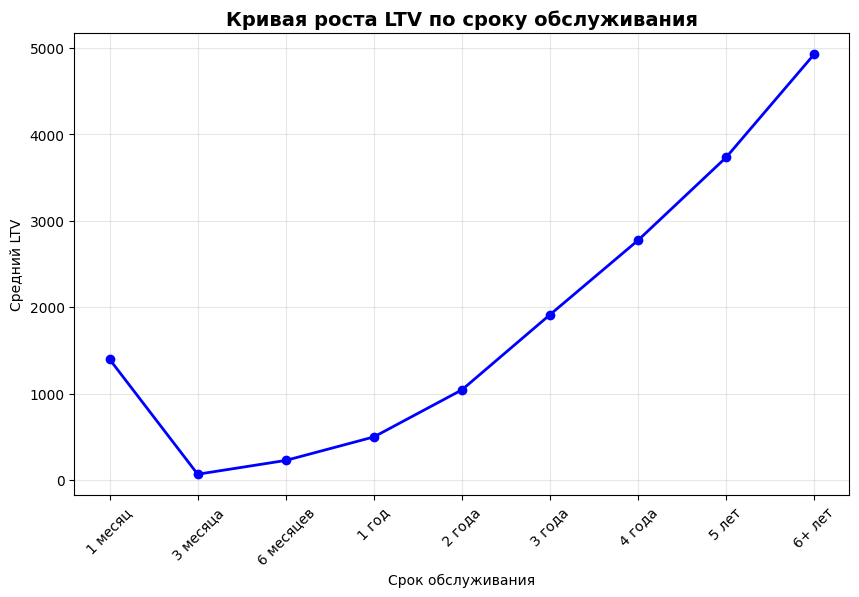

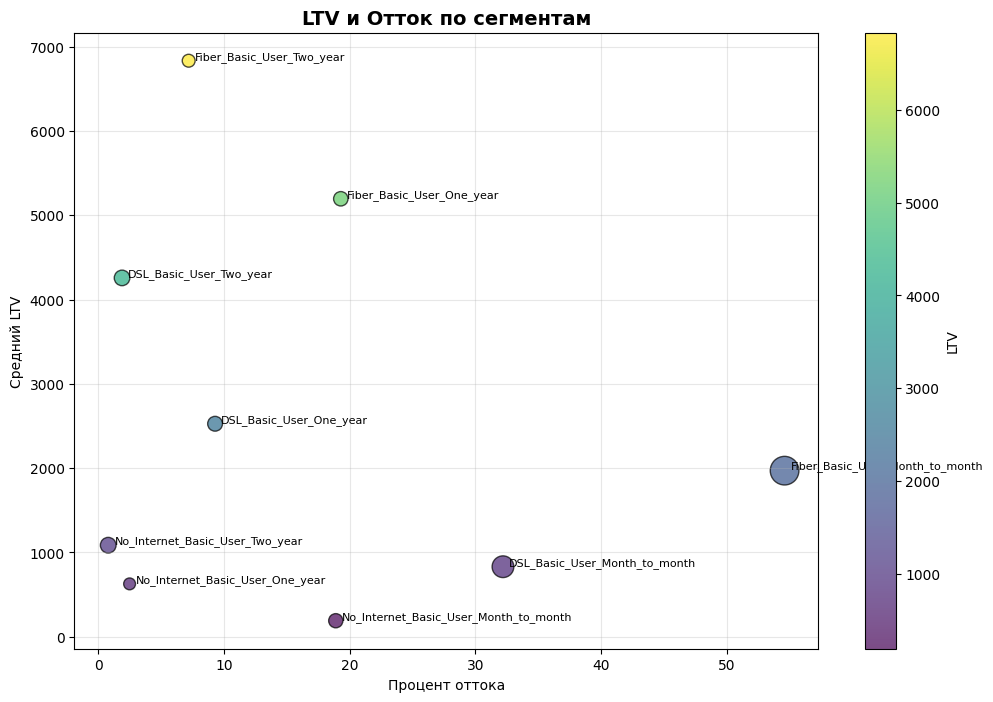

In [25]:
plt.figure(figsize=(10,6))
plt.plot(ltv_by_group.index, ltv_by_group.values,
         marker='o', linewidth=2, color='blue')
plt.title('Кривая роста LTV по сроку обслуживания', fontsize=14, fontweight='bold')
plt.xlabel('Срок обслуживания')
plt.ylabel('Средний LTV')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

ltv_by_segment = data.groupby('customer_segment')['TotalCharges'].mean()

segment_plot = segment_retention.copy()
segment_plot['LTV'] = ltv_by_segment

plt.figure(figsize=(12,8))
scatter = plt.scatter(segment_plot['Процент_оттока'],
                      segment_plot['LTV'],
                      s=segment_plot['Количество']*0.2,   # bubble size = количество клиентов в сегменте
                      c=segment_plot['LTV'],
                      cmap='viridis', alpha=0.7, edgecolors='k')

plt.title('LTV и Отток по сегментам', fontsize=14, fontweight='bold')
plt.xlabel('Процент оттока')
plt.ylabel('Средний LTV')

for idx, row in segment_plot.iterrows():
    plt.text(row['Процент_оттока']+0.5, row['LTV']+20, idx, fontsize=8)

plt.colorbar(scatter, label='LTV')
plt.grid(True, alpha=0.3)
plt.show()



# Основные выводы анализа:
## Ключевые факторы оттока:
- Month-to-month контракт (+42.7% churn);
- Оплата Electronic check (+45.3%);
- Fiber optic без доп. сервисов (+55%);
- Высокий MonthlyCharges (средний у ушедших $74 vs $61 у лояльных);
## Воронка удержания:
- Наибольший отток в первые 3–6 месяцев (59% и 47%);
- После 2 лет клиенты становятся гораздо стабильнее (отток < 20%);

## Сегменты с высоким риском:
- Fiber_Basic_User_Month_to_month (отток ~55%);
- DSL_Basic_User_Month_to_month (отток ~32%);
## Первый месяц — зона риска:
- 20% всего оттока приходится на 1-й месяц;
- Основные характеристики: контракт Month-to-month, метод оплаты Electronic check;
## Экономический эффект:
- Средний LTV «лояльных» клиентов в 10 раз выше, чем у ушедших в первый год;
- Потери от оттока составляют миллионы $ в год;
## Бизнес-рекомендации:
- Удержание новых клиентов: создать welcome-программу (скидки, бонусы в первый год);
- Изменение методов оплаты: стимулировать переход с Electronic check на автосписания;
- Фокус на Fiber optic: предлагать обязательные пакеты безопасности (OnlineSecurity, TechSupport);
- Контракты: стимулировать переход с месячного на годовой контракт (например, через скидки);
- Таргетировать сегменты с высоким риском (Fiber_Basic_User_Month_to_month, DSL_Basic_User_Month_to_month).
